In [ ]:
!pip install gradio
!pip install opendatasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.0 MB/s eta

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import gradio as gr
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#download dataset from kaggle
import opendatasets as od
od.download('https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pragyapuri
Your Kaggle Key: ··········


100%|██████████| 199k/199k [00:00<00:00, 51.9MB/s]


Extracting archive ./house-prices-advanced-regression-techniques/house-prices-advanced-regression-techniques.zip to ./house-prices-advanced-regression-techniques


# Pre Processing

In [ ]:
trainData = pd.read_csv("/content/house-prices-advanced-regression-techniques/train.csv")
testData = pd.read_csv("/content/house-prices-advanced-regression-techniques/test.csv")

X = trainData.drop(['SalePrice'], axis = 1)
y = trainData['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

def preprocessing(data):
  le = LabelEncoder()


  data['Kitchen']= 0
  data['Luxury'] = 0

  for i in data.index:
    if(data['KitchenQual'][i]=='Ex'):
      data['Kitchen'][i]=10
    elif(data['KitchenQual'][i]=='Gd'):
      data['Kitchen'][i]=8
    elif(data['KitchenQual'][i]=='TA'):
      data['Kitchen'][i]=6
    elif(data['KitchenQual'][i]=='Fa'):
      data['Kitchen'][i]=4

    # Luxury - Miscellaneous Features, Fireplace, Pool, CentralAir,  etc.
    if(data['MiscFeature'][i]=='Shed'):
      data['Luxury'][i] += 1
    elif(data['MiscFeature'][i]=='Gar2'):
      data['Luxury'][i] += 1
    elif(data['MiscFeature'][i]=='TenC'):
      data['Luxury'][i] += 2
    elif(data['MiscFeature'][i]=='Othr'):
      data['Luxury'][i] += 1

    if(data['CentralAir'][i] == 'Y'):
      data['Luxury'][i] += 1

    if(data['HeatingQC'][i]=='Ex'):
      data['Luxury'][i]+=1
    elif(data['HeatingQC'][i]=='Gd'):
      data['Luxury'][i]+=0.8
    elif(data['HeatingQC'][i]=='TA'):
      data['Luxury'][i]+=0.6
    elif(data['HeatingQC'][i]=='Fa'):
      data['Luxury'][i]+=0.4
    elif(data['HeatingQC'][i]=='Po'):
      data['Luxury'][i]+=0.2

    data['Luxury'][i] += data['Fireplaces'][i]

  data['SF'] = data['1stFlrSF'] + data['2ndFlrSF'] + data['TotalBsmtSF']
  final_params = data[['Id', 'SF', 'TotRmsAbvGrd', 'OverallQual', 'Kitchen', 'GarageArea', 'Luxury']]
  foundation = le.fit_transform(data.Foundation)
  final_params['Foundation'] = foundation
  final_params = final_params.join(pd.get_dummies(data.MSZoning)) # One Hot Encoding

  return final_params

X_train = preprocessing(X_train)
X_test = preprocessing(X_test)
testData = preprocessing(testData)

# Dropping entries with null values in them
testData.drop([660, 1116], inplace = True)

In [ ]:
rmse = [] #to store rmse values for different k
min_error = np.Infinity
min_K = 0
for K in range(1, 26):
    model = KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = math.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse.append(error) #store rmse values
    if(error < min_error):
      min_error = error
      min_K = K
    print('RMSE value for k = ' , K , 'is:', error)

RMSE value for k =  1 is: 49221.189811839686
RMSE value for k =  2 is: 46692.57119429802
RMSE value for k =  3 is: 45417.66935606738
RMSE value for k =  4 is: 43584.40535736731
RMSE value for k =  5 is: 43537.16136440225
RMSE value for k =  6 is: 42881.95504488854
RMSE value for k =  7 is: 42819.29646304198
RMSE value for k =  8 is: 42609.550653927115
RMSE value for k =  9 is: 42748.6557362036
RMSE value for k =  10 is: 42768.65214346122
RMSE value for k =  11 is: 42407.89773296011
RMSE value for k =  12 is: 42196.91356799522
RMSE value for k =  13 is: 42239.553209895406
RMSE value for k =  14 is: 42206.375714965994
RMSE value for k =  15 is: 41870.97351796324
RMSE value for k =  16 is: 42140.58027263573
RMSE value for k =  17 is: 41971.67009780229
RMSE value for k =  18 is: 41970.250307156275
RMSE value for k =  19 is: 42115.53167616738
RMSE value for k =  20 is: 42170.618958542604
RMSE value for k =  21 is: 41913.72288152693
RMSE value for k =  22 is: 41979.68593536504
RMSE value for

## Plotting the curve

<Axes: >

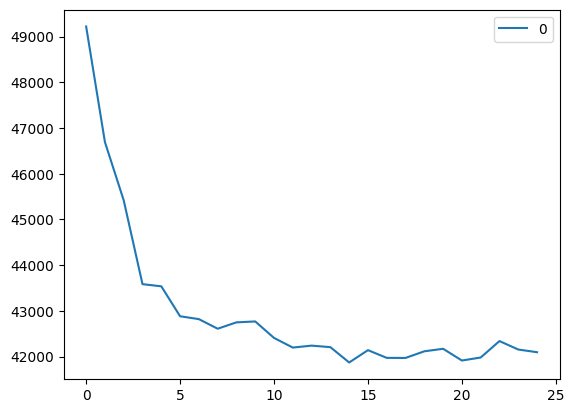

In [ ]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse) #elbow curve
curve.plot()

## Testing on already known data

In [ ]:
model = KNeighborsRegressor(n_neighbors = min_K)
model.fit(X_train, y_train)  # fit the model
pred = model.predict(X_test) #make prediction on test set
print(model.score(X_test, y_test))
predictions = pd.DataFrame({
    'Id':X_test.Id,
    'Actual_SalePrice': y_test,
    'Predicted_SalePrice':pred,
})

# Saving the model
filename = 'house_model.sav'
pickle.dump(model, open(filename, 'wb'))

predictions

0.6393821729900788


,Id,Actual_SalePrice,Predicted_SalePrice
631,632,209500,225804.066667
260,261,176000,219245.333333
677,678,109500,115366.666667
513,514,134000,156130.000000
345,346,140200,157532.666667
...,...,...,...
948,949,192500,188335.400000
917,918,135000,156703.333333
440,441,555000,436876.133333
545,546,229000,262890.000000


## Testing on the new data

In [ ]:
# load the model from disk
saved_model = pickle.load(open(filename, 'rb'))

predictions = saved_model.predict(testData)
predictions = pd.DataFrame({
    'Id':testData.Id,
    'SalePrice':predictions,
})

predictions

,Id,SalePrice
0,1461,130850.133333
1,1462,170626.000000
2,1463,176694.600000
3,1464,173102.666667
4,1465,180567.933333
...,...,...
1454,2915,120095.000000
1455,2916,121786.666667
1456,2917,172076.266667
1457,2918,123995.000000
